In [53]:
from functools import partial
from itertools import product
import pandas as pd
from sklearn.pipeline import Pipeline
from friendly_guacamole.transforms import (
    FilterSamples,
    UniFrac,
    RarefactionBIOM,
    PCoA,
    AsDense,
    CLR,
)
from friendly_guacamole.datasets import SoilsDataset
from umap import UMAP


In [41]:
soils_data = SoilsDataset('data/soils')
tree = soils_data.apply('tree', 'path')

RAREFACTION_DEPTH = 500

Files already downloaded and verified


In [42]:
min_count_filter = FilterSamples(min_count=RAREFACTION_DEPTH)

soil_mf = soils_data['metadata']
soil_table = soils_data['table']
metadata = soil_mf.set_index('sample_name')
soil_table = soil_table.filter(metadata.index)
table = min_count_filter.fit_transform(soil_table)
metadata = metadata.loc[table.ids('sample')]

In [43]:
rarefied_table = RarefactionBIOM(RAREFACTION_DEPTH).fit_transform(table)

In [71]:
def postprocess_umap(results):
    return pd.DataFrame(results, columns=[f'PC{i + 1}'
                                          for i in range(results.shape[1])])

In [107]:
prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': Pipeline([
            ('asdense', AsDense()),
            ('clr', CLR()),
        ]),
    },
    {
        'name': 'Bray-Curtis',
        'metric': 'braycurtis',
        'pipeline': AsDense(),
    },
    {
        'name': 'Jaccard',
        'metric': 'jaccard',
        'pipeline': AsDense(),
    },
    {
        'name': 'UniFrac',
        'metric': 'precomputed',
        'pipeline': UniFrac(tree),
    },
    {
        'name': 'Weighted UniFrac',
        'metric': 'precomputed',
        'pipeline': UniFrac(tree,
                            unifrac_method='weighted_unnormalized'
                            ),
    },
]

In [115]:
embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
    },
    {
        'method': 'UMAP\nNeighbors=15',
        'pipeline': partial(UMAP, min_dist=1, random_state=724),
        'postprocess': postprocess_umap,
    },
    {
        'method': 'UMAP\nNeighors=80',
        'pipeline': partial(UMAP, min_dist=1, n_neighbors=80, random_state=825),
        'postprocess': postprocess_umap,
    },
]

In [116]:
results = dict()

for prep, emb in product(prep_tables, embedding_methods):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    results[(name, method)] = result


/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/s

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns


In [118]:
v_position_map = {x['name']: i for i, x in enumerate(prep_tables)}
h_position_map = {x['method']: i for i, x in enumerate(embedding_methods)}


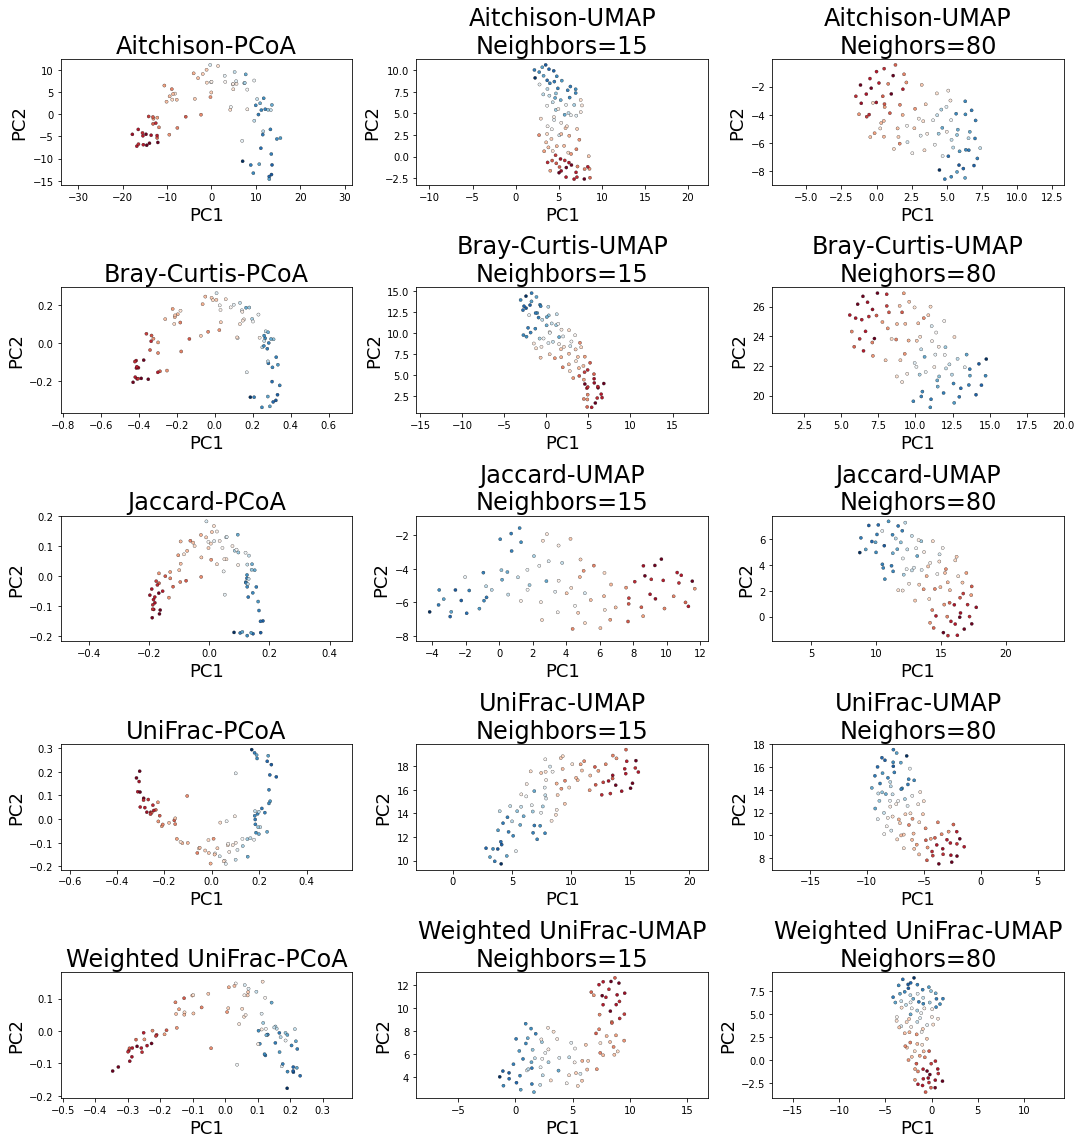

In [124]:
fig, axs = plt.subplots(len(v_position_map), len(h_position_map),
                        figsize=(15, 8 * 6 / 3),
                        )
for name, method in results:
        i = v_position_map[name]
        j = h_position_map[method]
        res = results[(name, method)]
        res.index = metadata.index
        res = res.join(metadata)

        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue='ph',
            data=res,
            ax=axs[i][j],
            s=10,
            edgecolor='k',
            palette='RdBu',
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)

        g.set_xlabel('PC1', color='black', fontsize=18)
        g.set_ylabel('PC2', color='black', fontsize=18),

plt.tight_layout()
plt.savefig('results/2.0-real-data-soil-ordination.png')
plt.show()